In [16]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import warnings
warnings.filterwarnings('ignore', message="Non-invertible starting MA parameters found")

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

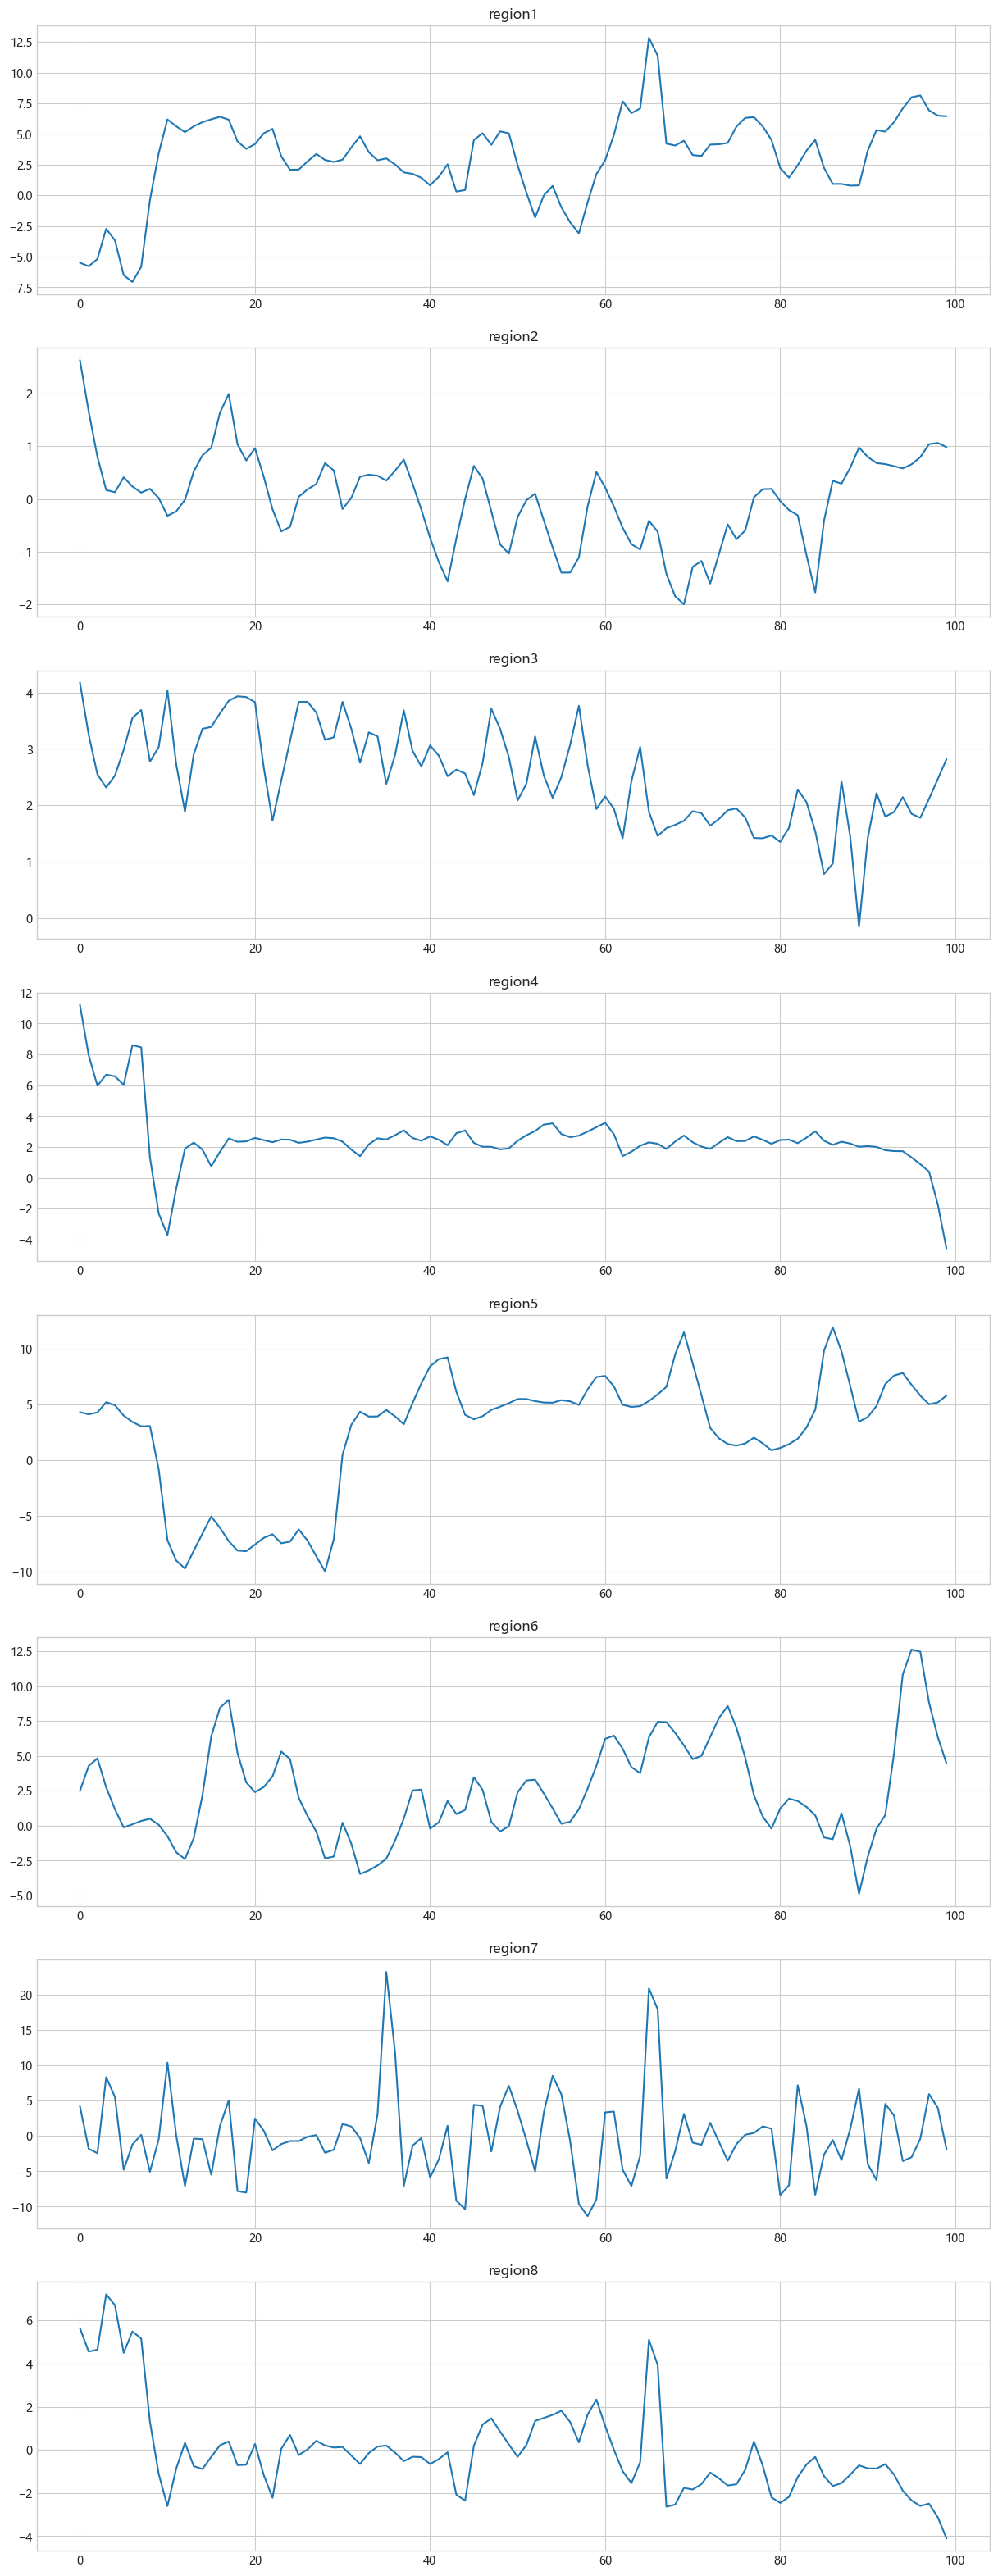

In [17]:
data = pd.read_excel('数据文件.xls')

# 数据分布
fig = plt.figure(figsize=(15, 40))
for i in range(1, 9):
    ax = fig.add_subplot(8, 1, i)
    ax.plot(data.iloc[:, i])
    ax.set_title('region%d' % i)

# plt.savefig('图片\原始数据图.png')

In [18]:
def ADF(ts):

    index = ['ADF统计值', 'p值', '临界值(1%)', '临界值(5%)', '临界值(10%)']
    df = pd.DataFrame(index=index, columns=['0阶差分', '1阶差分'])

    result = adfuller(ts)
    df['0阶差分'] = [result[0], result[1], result[4]['1%'], result[4]['5%'], result[4]['10%']]

    ts = ts.diff().dropna()
    result = adfuller(ts)
    df['1阶差分'] = [result[0], result[1], result[4]['1%'], result[4]['5%'], result[4]['10%']]

    return df

for i in range(1, 9):
    ts = data.iloc[:, i]
    print('='*30)
    print('region%d:' % i)

    # ADF检验数据
    print(ADF(ts))

region1:
              0阶差分      1阶差分
ADF统计值   -4.346335 -5.568501
p值        0.000369  0.000001
临界值(1%)  -3.501912 -3.501137
临界值(5%)  -2.892815 -2.892480
临界值(10%) -2.583454 -2.583275
region2:
              0阶差分      1阶差分
ADF统计值   -1.062038 -4.153298
p值        0.729971  0.000790
临界值(1%)  -3.506944 -3.508783
临界值(5%)  -2.894990 -2.895784
临界值(10%) -2.584615 -2.585038
region3:
              0阶差分          1阶差分
ADF统计值   -0.906856 -6.415095e+00
p值        0.785706  1.849679e-08
临界值(1%)  -3.504343 -3.504343e+00
临界值(5%)  -2.893866 -2.893866e+00
临界值(10%) -2.584015 -2.584015e+00
region4:
              0阶差分      1阶差分
ADF统计值    2.140717 -3.802654
p值        0.998830  0.002880
临界值(1%)  -3.506944 -3.505190
临界值(5%)  -2.894990 -2.894232
临界值(10%) -2.584615 -2.584210
region5:
              0阶差分          1阶差分
ADF统计值   -1.894497 -6.430970e+00
p值        0.334654  1.697811e-08
临界值(1%)  -3.499637 -3.500379e+00
临界值(5%)  -2.891831 -2.892152e+00
临界值(10%) -2.582928 -2.583100e+00
region6:
              0阶差分      1阶差分

In [19]:
# diff_ 标记为1的数据需要进行一阶差分
diff_ = [0, 1, 1, 1, 1, 1, 0, 1]

for i in range(1, 9):
    ts = data.iloc[:, i]
    if diff_[i - 1] == 1:
        ts = ts.diff().dropna()

    print('='*30)
    print('region%d:' % i)
    # 进行Ljung-Box检验
    # 判断准则：
    # 对于每一个滞后阶数（行索引），
    # LB统计量小于选定置信水平下的临界值，或者p值大于显著性水平（如0.05），不能拒绝原假设，序列为白噪声；
    # LB统计量大于选定置信水平下的临界值，或者p值小于显著性水平（如0.05），拒绝原假设，序列非白噪声；

    print(acorr_ljungbox(ts, lags=10).rename(columns={'lb_stat': 'LB统计量', 'lb_pvalue': 'p值'}))

region1:
         LB统计量            p值
1    75.049264  4.591140e-18
2   117.414022  3.190576e-26
3   142.033426  1.377193e-30
4   154.921539  1.794187e-32
5   159.401504  1.327726e-32
6   159.888029  6.254050e-32
7   160.472362  2.551472e-31
8   165.454077  1.155412e-31
9   174.018424  8.970808e-33
10  181.802090  9.898315e-34
region2:
        LB统计量            p值
1   13.775785  2.059740e-04
2   17.763874  1.388749e-04
3   21.016976  1.044250e-04
4   24.695960  5.791031e-05
5   29.298711  2.025937e-05
6   29.551166  4.783307e-05
7   30.933425  6.395647e-05
8   35.747388  1.953184e-05
9   35.782343  4.333143e-05
10  50.335343  2.315568e-07
region3:
        LB统计量            p值
1    0.117785  7.314498e-01
2   36.444414  1.219540e-08
3   36.686838  5.359662e-08
4   38.615600  8.363573e-08
5   40.717996  1.069760e-07
6   40.807132  3.160335e-07
7   41.302319  7.082747e-07
8   41.586392  1.619046e-06
9   41.590779  3.903704e-06
10  44.350228  2.847480e-06
region4:
        LB统计量            p值
1

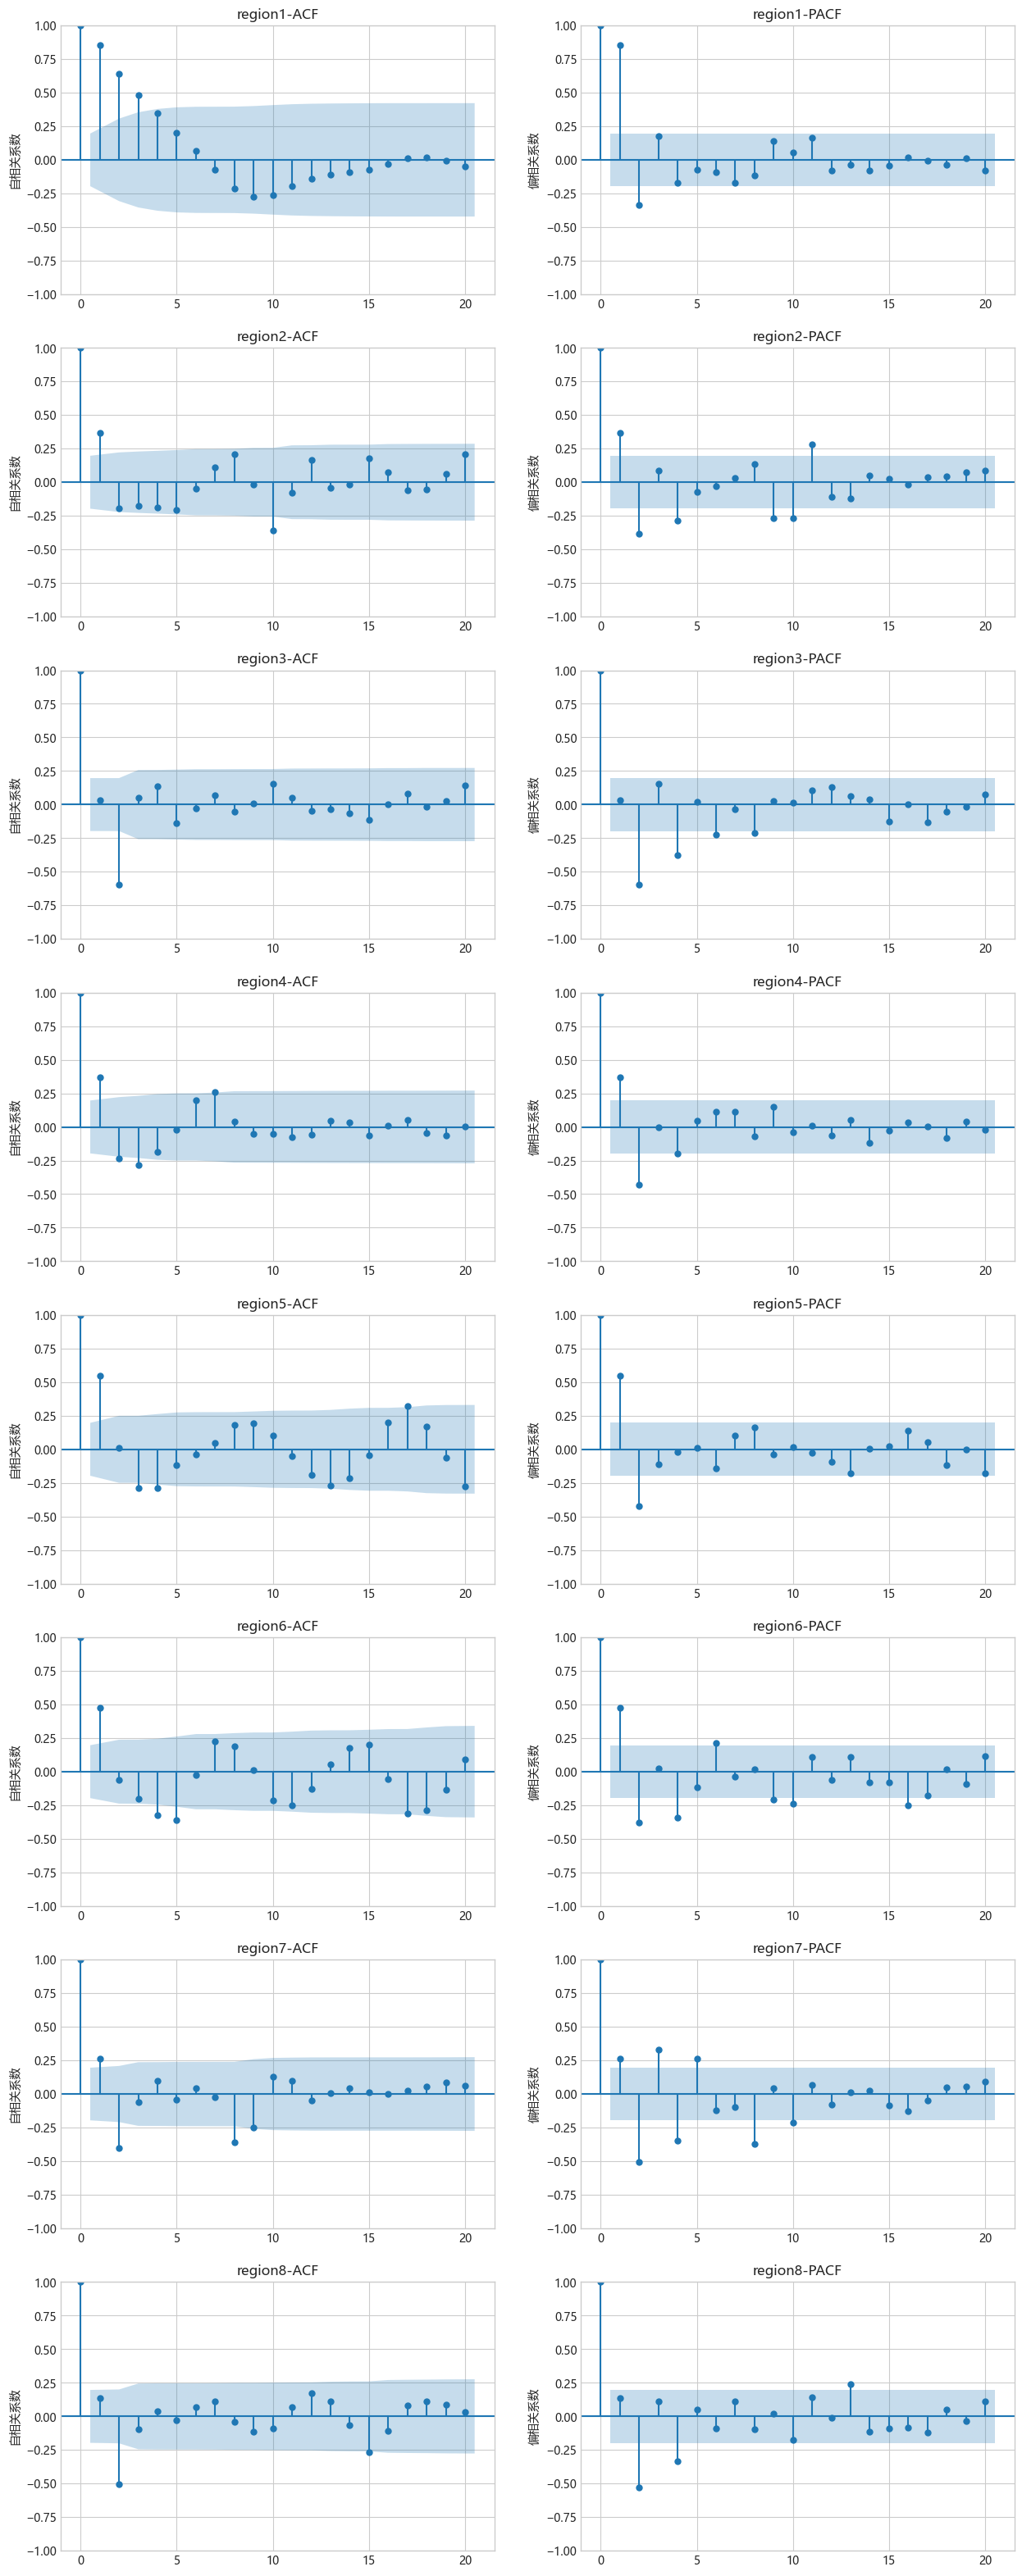

In [20]:
fig, ax = plt.subplots(8, 2, figsize=(15, 40))

for i in range(1, 9):

    # 绘制时间序列的ACF和PACF图
    # 图表每一行代表一个地区
    ts = data.iloc[:, i]
    if diff_[i - 1] == 1:
        ts = ts.diff().dropna()

    plot_acf(ts, ax=ax[i-1, 0])
    plot_pacf(ts, ax=ax[i-1, 1], method='ywm')
    ax[i-1, 0].set_title('region%d-ACF' % i)
    ax[i-1, 1].set_title('region%d-PACF' % i)
    ax[i-1, 0].set_ylabel('自相关系数')
    ax[i-1, 1].set_ylabel('偏相关系数')

# plt.savefig('图片\ACF和PACF图.png')

In [21]:
# ARIMA(Autoregressive Integrated Moving Average model)差分整合移动平均自回归模型
# 模型的参数(p, d, q), 每一个元组对应一个地区的模型参数(参数的设置由ACF、PACF图和ADF检验得来)
# p: 时间序列数据本身的滞后数(属于Autoregressive model自回归模型)
# d: 数据进行差分的次数
# q: 预测误差的滞后数(属于Moving average model滑动平均模型)
param = [(2, 0, 3), (2, 1, 1), (0, 1, 2), (2, 1, 1), (2, 1, 1), (2, 1, 1), (2, 0, 2), (0, 1, 0)]
dw = pd.DataFrame(index=['region%d' % i for i in range(1, 9)], columns=['统计量'])

resid, forecast = [], []

for i in range(1, 9):
    ts = data.iloc[:, i]

    # 进行自动 ARIMA 模型拟合(想看算法拟合的参数可以把下面四行的#去掉)
    # from pmdarima import auto_arima
    # model = auto_arima(ts)
    # order = model.order
    # print(order)

    # 训练 ARIMA 模型
    model = ARIMA(ts, order=param[i - 1])
    result = model.fit()

    # 残差
    resid.append(result.resid)

    # 预测
    forecast.append(result.predict(start=0, end=len(ts)-1, typ='levels'))

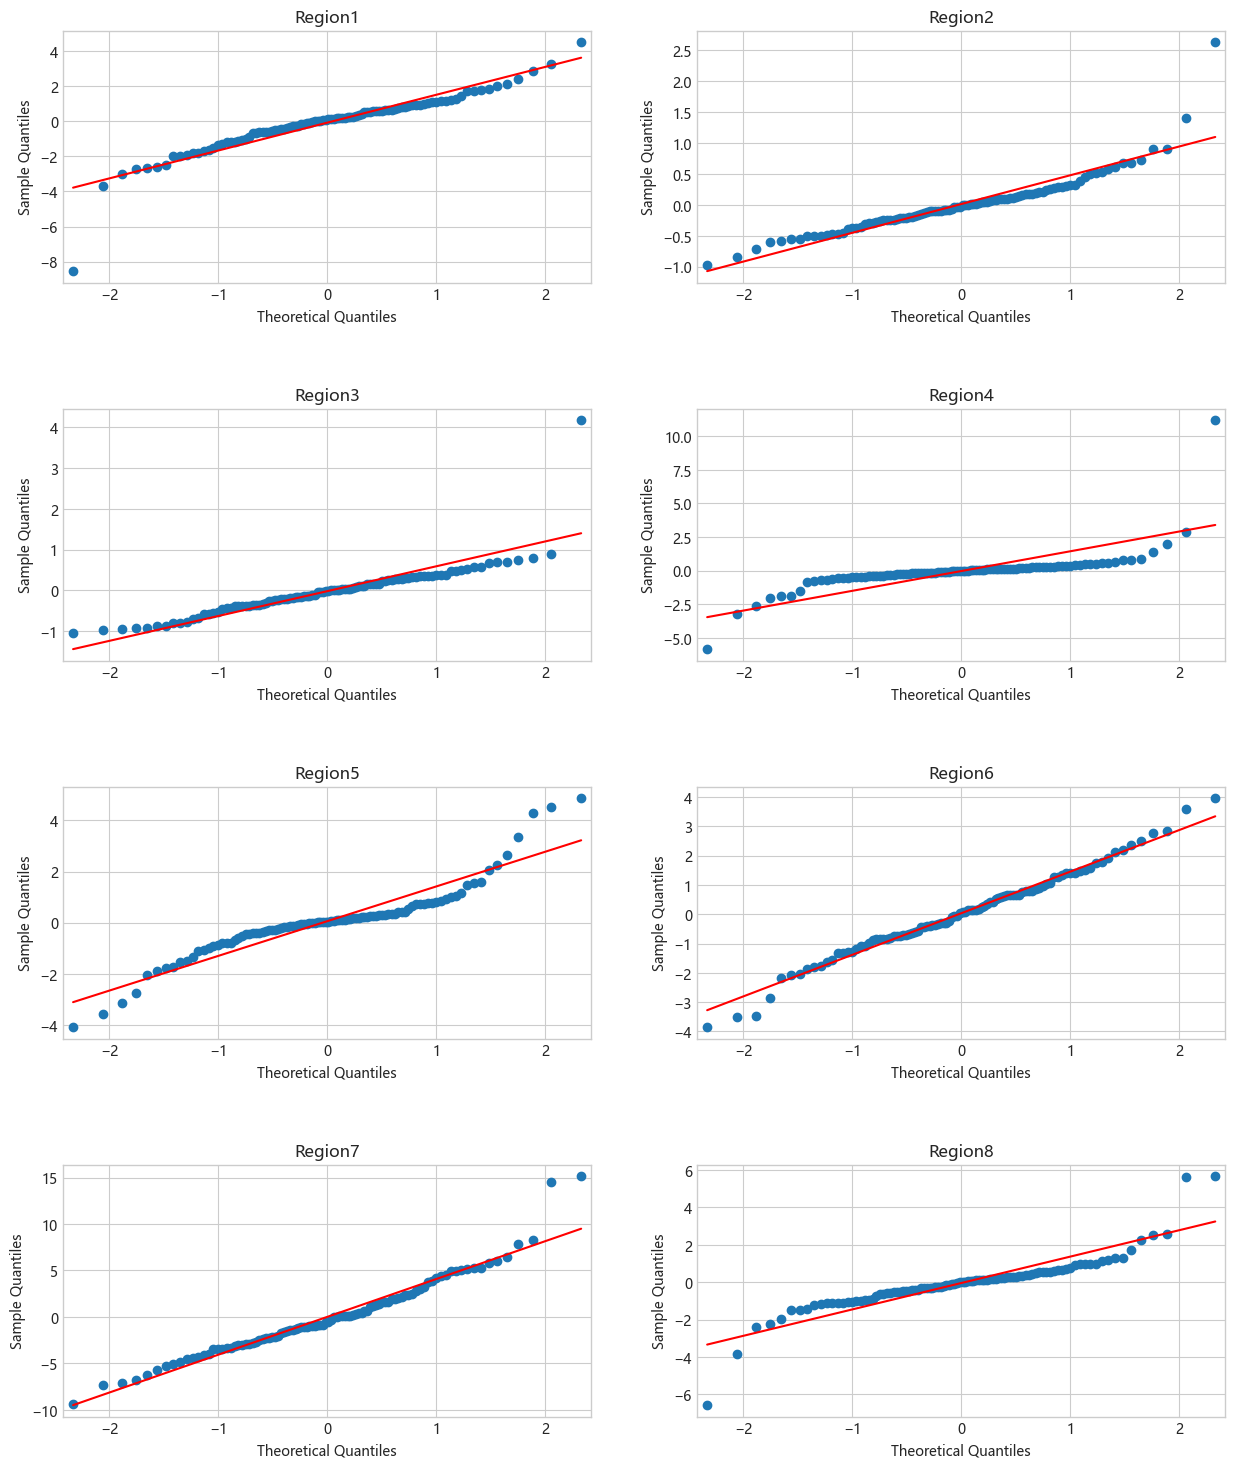

In [22]:
fig, ax = plt.subplots(4, 2, figsize=(15, 18))
for i in range(0, 4):

    # 绘制残差的概率图
    # 数据点大致分布在直线附近，说明残差近似服从正态分布

    sm.qqplot(resid[2*i], ax=ax[i, 0], line='s')
    sm.qqplot(resid[2*i+1], ax=ax[i, 1], line='s')
    ax[i, 0].set_title('Region%d' % (2*i+1))
    ax[i, 1].set_title('Region%d' % (2*i+2))
    fig.subplots_adjust(hspace=0.5)

# plt.savefig('图片\概率图.png')

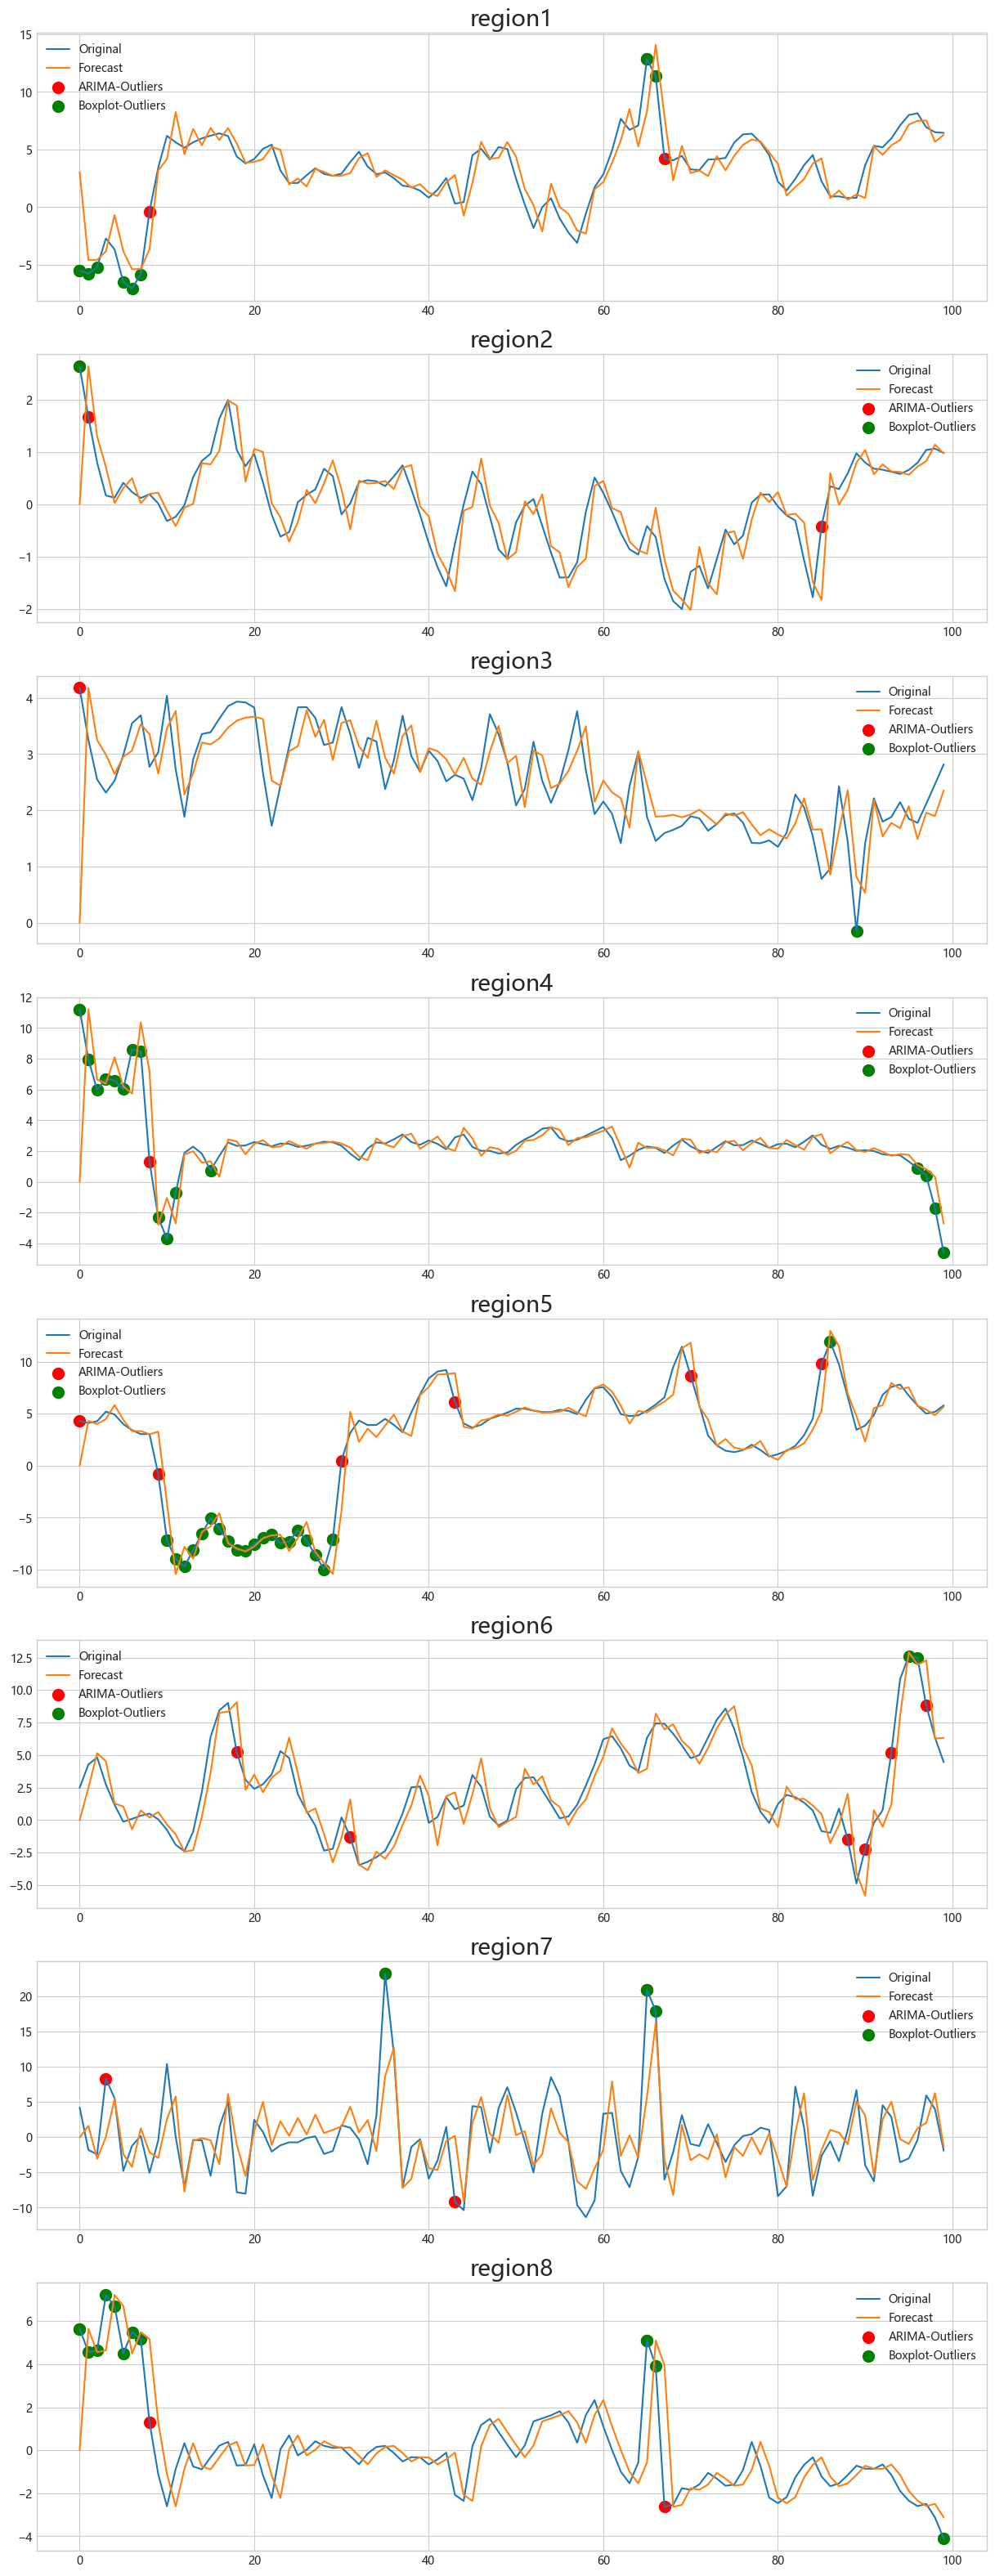

In [23]:
fig, ax = plt.subplots(8, 1, figsize=(15, 40))
for i in range(1, 9):

    ts = data.iloc[:, i]

    ax[i-1].plot(ts, label='Original')
    ax[i-1].plot(forecast[i-1], label='Forecast')

    # 因残差近似服从正态分布，所以基于2σ准则判断异常点
    resid_std = resid[i-1].std()
    resid_mean = resid[i-1].mean()

    # 不在（μ - 2σ，μ + 2σ）区间内的布尔索引，即异常值的布尔索引
    outliers = (resid_mean + 2 * resid_std < resid[i-1]) | (resid[i-1] < resid_mean - 2 * resid_std)

    # ARIMA模型标注的异常点为红色
    # 箱形图标注的异常点为绿色，有可能把同一个位置的红色点覆盖掉
    ax[i-1].scatter(np.arange(100)[outliers], ts[outliers], c='red', s=100, label='ARIMA-Outliers')

    # 箱形图
    q1, q3 = ts.quantile(q=[0.25, 0.75])
    iqr = q3 - q1
    outliers_index = (ts < (q1 - 1.5 * iqr)) | (ts > (q3 + 1.5 * iqr))
    ax[i-1].scatter(np.arange(100)[outliers_index], ts[outliers_index], c='green', s=100, label='Boxplot-Outliers')
    ax[i-1].set_title('region%d' % i, fontsize=20)
    ax[i-1].legend()

# plt.savefig('图片\模型预测效果图.png')